In [4]:
#Import Beautiful Soup, lxml, requests to scrap data from Toronto Neighborhood in Wikipedia
!pip install wikipedia
import wikipedia as wp
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print("Libraries Imported!")

Libraries Imported!


<h2>Step 1</h2>

In [7]:
#Get the html source
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(html)[0]

#Delete rows where Borough is 'Not assigned'
df = df[df.Borough!= "Not assigned"]

#Combine all neighbourhoods where postcode and Borough are the same
df = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
#if Neighbourhood is not assigned, replace by borough name
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

# define the dataframe columns
column_names = ['Postcode','Borough', 'Neighborhood'] 

# instantiate the dataframe
df.columns = column_names

df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h2>Step 2</h2>

In [8]:
import pandas as pd
import io
import requests
url="https://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

dfc = df.join(c.set_index('Postal Code'), on='Postcode')
dfc.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h2>Step 3</h2>

In [9]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dfc['Latitude'], dfc['Longitude'], dfc['Borough'], dfc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

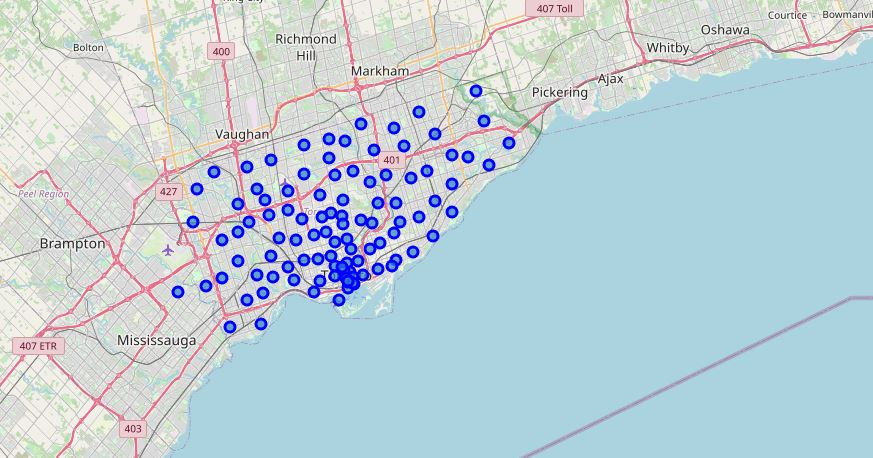

In [11]:
CLIENT_ID = 'HDMAQU1W5J4VEGW30OKIGS5XM3NT4QSNXPYP0JUJYXNSDG0C' # your Foursquare ID
CLIENT_SECRET = '33PMQ4ITASOWYRFOW0GD3UIV4E4AWVWGANIYM4UGQGBVLDLK' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
radius = 500
#print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

Your credentails:
CLIENT_ID: HDMAQU1W5J4VEGW30OKIGS5XM3NT4QSNXPYP0JUJYXNSDG0C
CLIENT_SECRET:33PMQ4ITASOWYRFOW0GD3UIV4E4AWVWGANIYM4UGQGBVLDLK


'https://api.foursquare.com/v2/venues/search?client_id=HDMAQU1W5J4VEGW30OKIGS5XM3NT4QSNXPYP0JUJYXNSDG0C&client_secret=33PMQ4ITASOWYRFOW0GD3UIV4E4AWVWGANIYM4UGQGBVLDLK&ll=43.6534817,-79.3839347&v=20180604&radius=500&limit=100'

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-12-0d7ff72a3d51>:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.country,location.formattedAddress,location.address,location.crossStreet,location.postalCode,location.city,location.state,location.neighborhood
0,4c093ee0340720a153728493,City Hall Council Chambers,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1605730452,False,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,CA,Canada,[Canada],NaN,NaN,NaN,NaN,NaN,NaN
1,4ad4c05ef964a5208ff620e3,Toronto City Hall,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1605730452,False,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,CA,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",100 Queen St. W.,at Bay St.,M5H 2N2,Toronto,ON,NaN
2,5b193c42598e64002ca79b96,City of Toronto Civic Innovation Office,"[{'id': '4bf58dd8d48988d129941735', 'name': 'C...",v-1605730452,False,43.653454,-79.383952,"[{'label': 'display', 'lat': 43.653454, 'lng':...",3,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN
3,4c8fe71804a1b60ca0e9a23e,Toronto Municipal Employees Credit Union,"[{'id': '4bf58dd8d48988d10a951735', 'name': 'B...",v-1605730452,False,43.653231,-79.382894,"[{'label': 'display', 'lat': 43.65323066711299...",88,CA,Canada,"[100 Queen St W (in City Hall), Toronto ON, Ca...",100 Queen St W,in City Hall,NaN,Toronto,ON,NaN
4,50885719498ea7b5aab3a74c,GoodLife Fitness Toronto Bell Trinity Centre,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",v-1605730452,False,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",130,CA,Canada,"[483 Bay St, Toronto ON M5G 2C9, Canada]",483 Bay St,NaN,M5G 2C9,Toronto,ON,NaN


In [13]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,lat,lng,labeledLatLngs,distance,cc,country,formattedAddress,address,crossStreet,postalCode,city,state,neighborhood,id
0,City Hall Council Chambers,City Hall,43.651827,-79.383949,"[{'label': 'display', 'lat': 43.65182710471462...",184,CA,Canada,[Canada],NaN,NaN,NaN,NaN,NaN,NaN,4c093ee0340720a153728493
1,Toronto City Hall,City Hall,43.653140,-79.383967,"[{'label': 'display', 'lat': 43.65313989695342...",38,CA,Canada,"[100 Queen St. W. (at Bay St.), Toronto ON M5H...",100 Queen St. W.,at Bay St.,M5H 2N2,Toronto,ON,NaN,4ad4c05ef964a5208ff620e3
2,City of Toronto Civic Innovation Office,City Hall,43.653454,-79.383952,"[{'label': 'display', 'lat': 43.653454, 'lng':...",3,CA,Canada,"[100 Queen St W, Toronto ON M5H 2N2, Canada]",100 Queen St W,NaN,M5H 2N2,Toronto,ON,NaN,5b193c42598e64002ca79b96
3,Toronto Municipal Employees Credit Union,Bank,43.653231,-79.382894,"[{'label': 'display', 'lat': 43.65323066711299...",88,CA,Canada,"[100 Queen St W (in City Hall), Toronto ON, Ca...",100 Queen St W,in City Hall,NaN,Toronto,ON,NaN,4c8fe71804a1b60ca0e9a23e
4,GoodLife Fitness Toronto Bell Trinity Centre,Gym,43.653436,-79.382314,"[{'label': 'display', 'lat': 43.653436, 'lng':...",130,CA,Canada,"[483 Bay St, Toronto ON M5G 2C9, Canada]",483 Bay St,NaN,M5G 2C9,Toronto,ON,NaN,50885719498ea7b5aab3a74c


In [14]:
#Create function to know how many venues there are in Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#List of Neighborhood that have venues in Toronto
toronto_venues = getNearbyVenues(names=dfc['Neighborhood'],
                                   latitudes=dfc['Latitude'],
                                   longitudes=dfc['Longitude']
                                  )

toronto_venues.head()

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [16]:
print('{} venues were returned by Foursquare.'.format(toronto_venues.shape[0]))
toronto_venues.head()


2166 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
manhattan_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Road,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0

In [21]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1             Clothing Store   0.2
2             Breakfast Spot   0.2
3                     Lounge   0.2
4               Skating Rink   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1             Gym  0.14
2  Sandwich Place  0.14
3             Pub  0.14
4     Coffee Shop  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2                Pizza Place  0.05
3                   Pharmacy  0.05
4  Middle Eastern Restaurant  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1   Chinese Restaurant  0.25
2                 Bank  0.25
3                 Café  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.09
1           Sandw

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Clothing Store
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Coffee Shop,Pub,Pharmacy
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Deli / Bodega,Shopping Mall
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Distribution Center
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Greek Restaurant,Thai Restaurant


In [24]:
# set number of clusters
kclusters = 2

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

toronto_merged = dfc

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged = toronto_merged.dropna()


toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,Fast Food Restaurant,Yoga Studio,Drugstore,Discount Store,Distribution Center
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Construction & Landscaping,Bar,Yoga Studio,Dumpling Restaurant,Dive Bar
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Intersection,Breakfast Spot,Electronics Store,Restaurant,Medical Center
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Mexican Restaurant,Drugstore,Distribution Center
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Caribbean Restaurant,Fried Chicken Joint,Bank,Gas Station,Athletics & Sports


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

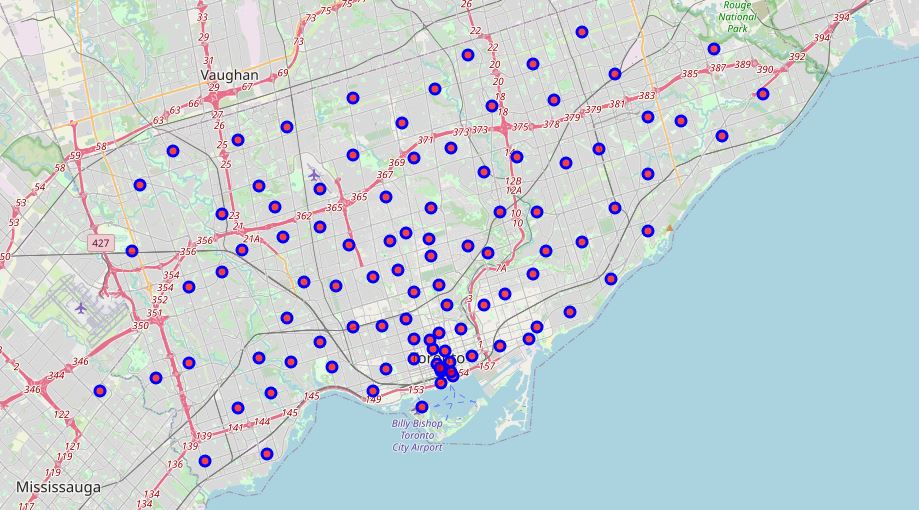

In [29]:
toronto_merged.loc[toronto_merged['ClusterLabels'] ==1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,Scarborough,1.0,Playground,Park,Bakery,Yoga Studio,Drugstore
23,North York,1.0,Park,Convenience Store,Yoga Studio,Drugstore,Discount Store
25,North York,1.0,Park,Food & Drink Shop,Yoga Studio,Drugstore,Discount Store
40,East York,1.0,Intersection,Park,Convenience Store,Drugstore,Discount Store
44,Central Toronto,1.0,Park,Swim School,Bus Line,Yoga Studio,Donut Shop
50,Downtown Toronto,1.0,Park,Trail,Playground,Tennis Court,Donut Shop
74,York,1.0,Park,Women's Store,Pool,Drugstore,Discount Store
79,North York,1.0,Bakery,Park,Construction & Landscaping,Yoga Studio,Dumpling Restaurant
98,York,1.0,Park,Yoga Studio,Drugstore,Discount Store,Distribution Center
